First, we need to create the training data for the neural network, i.e. evaluations of the CA rules. Given a singular centered seed of 1 in the middle of a 0s array, the CA can only expand out by radius 1 cell each iteration. That is, at maximum it can only grow in a triangle. So it's useful to make the length of the initial array twice as long as the number of iterations to see everything that could happen with a rule. Alternatively, we could just look at a already full window way down in the iterations. For now, we'll start with the seed with, say, 40 iterations.

In [1]:
import numpy as np
from automaton import Rule, next_state

def evaluated(index, niter, init=None, start=0):
    rule = Rule(index)
    if init is None:
        init = np.zeros(2*niter)
        init[niter] = 1
    matrix = np.zeros((niter + 1, len(init)))
    matrix[0, :] = init
    for i in range(niter):
        matrix[i + 1, :] = next_state(matrix[i, :], rule)
    return matrix[start:, :]

Now, let's just to make sure that this works properly...

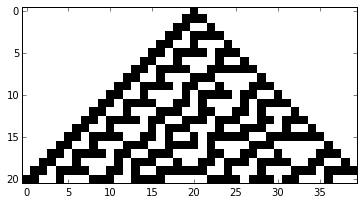

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(evaluated(30, 20), interpolation='nearest', cmap='Greys')
plt.show()

Cool, now every rule will be a $(n + 1) \times 2n$ matrix for $n$ iterations. And, we can unravel that to a long 1-dimensional vector for the input of the neural network. Let's now save all those unravelings for each rule:

In [3]:
from pyprind import ProgPercent

NITER = 20
inp = np.zeros((256, 2*NITER*(NITER + 1)))
progbar = ProgPercent(256)
for i in range(256):
    inp[i, :] = evaluated(i, NITER).flatten()
    progbar.update()

[100 %] elapsed[sec]: 4.520 | ETA[sec]: 0.000 
Total time elapsed: 4.520 sec


And the output layer will simply be a single number representing the class. We'll gather together all the unique classes of the CAs and assign a number to each.

In [4]:
from ca_train import ca_classes

unique_labels = set(ca_classes.values())
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {v: k for k, v in label2id.items()}
label2id

{'Chaotic': 5,
 'Complex': 3,
 'Fixed-Point': 2,
 'Null': 1,
 'Periodic': 4,
 'Two-Cycle': 0}

In [5]:
out = np.array([label2id[ca_classes[i]] for i in range(256)])

Now let's train that neural network!

In [6]:
from sklearn.svm import SVC

clf = SVC(degree=5)
clf.fit(inp, out)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=5, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [7]:
clf.score(inp, out)

0.53515625